In [1]:
import copy
from functools import partial
from typing import *

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import wandb
import wandb.apis

api = wandb.Api()

In [2]:
def load_one(run: wandb.apis.public.Run) -> Dict[str, Any]:
    if "count" in run.summary:
        task = run.config["task"]["name"]
        mc = run.summary["model_config"]
        score_key = dict(
            squad="match", triviaqa="match", cnn_dailymail="rougeL", wikitext_bpc="bpc"
        )[task]
        sparsity = copy.deepcopy(run.config["sparsity"])
        assert sparsity.pop("score", None) in [None, "sparse_q"]
        scores = [r[score_key] for r in run.summary["results"]]
        return dict(
            task=task,
            model=run.config["model"].split("/")[1].replace("-hf", "").lower(),
            n_heads=mc["num_attention_heads"] * mc["num_hidden_layers"],
            head_size=mc["hidden_size"]//mc["num_attention_heads"],
            **sparsity,
            prefill_length=run.summary["prefill_length"],
            score=np.mean(scores),
            score_stderr=np.sqrt(np.var(scores) / len(scores)),
        )

def load_sweep(experiment_name: str, *single_runs: str) -> pd.DataFrame:
    return pd.DataFrame.from_dict(filter(None, (
        load_one(run)
        for run in api.runs(
            "research/sparse-attention", {"$or": [
                {"config.name": experiment_name},
                *({"display_name": n} for n in single_runs)
            ]}
        )
    )))

def memory_transfers_attention_only(s: pd.Series, count_kv: bool = True, count_index: bool = True) -> int:
    kv_elements, index_elements = 0, 0  # per-head
    if s["name"] == "dense":
        # write 1*(k, v) + read all prefill_length*(k, v)
        kv_elements = (2 + 2 * s["prefill_length"]) * s["head_size"]

    elif s["name"] == "sparse_v":
        # write 1*(k, v) + read all prefill_length*k + read sparse_k*v
        kv_elements = (2 + s["prefill_length"] + s["k"]) * s["head_size"]

    elif s["name"] == "eviction":
        # write 1*(k, v) + read all sparse_k*(k, v)
        kv_elements = (2 + 2 * s["k"]) * s["head_size"]
        # read/write scores
        index_elements = (1 + 2 * s["prefill_length"])

    elif s["name"] == "ann":
        # write 1*(k, v) + read all sparse_k*(k, v)
        kv_elements = (2 + 2 * s["k"]) * s["head_size"]
        # read/write index
        index_elements = s["head_size"] + s["prefill_length"] * s["rank"]
        if s["reallocate_to_mean_value"]:
            index_elements += 2 * s["head_size"]

    else:
        assert False, s["name"]

    return (count_kv * kv_elements + count_index * index_elements) * s["n_heads"]

df = (
    load_sweep("RMOE-65-refresh")
    .pipe(lambda d: d.assign(transfers=d.apply(memory_transfers_attention_only, axis=1)))
    [["task", "model", "name", "k", "rank", "transfers", "score", "score_stderr"]]
)
df.head()

# Note - this sweep is missing some runs from pythia-2.8b due to OOM errors

,task,model,name,k,rank,transfers,score,score_stderr
0,cnn_dailymail,pythia-1.4b,ann,256.0,64.0,5.500625e+07,0.177893,0.003821
1,cnn_dailymail,pythia-1.4b,ann,256.0,32.0,4.020892e+07,0.178907,0.003778
2,wikitext_bpc,pythia-2.8b,ann,128.0,16.0,4.320648e+07,0.722447,0.006432
3,cnn_dailymail,pythia-1.4b,ann,256.0,16.0,3.281025e+07,0.181286,0.003786
4,cnn_dailymail,pythia-1.4b,ann,128.0,64.0,4.242334e+07,0.180038,0.003875


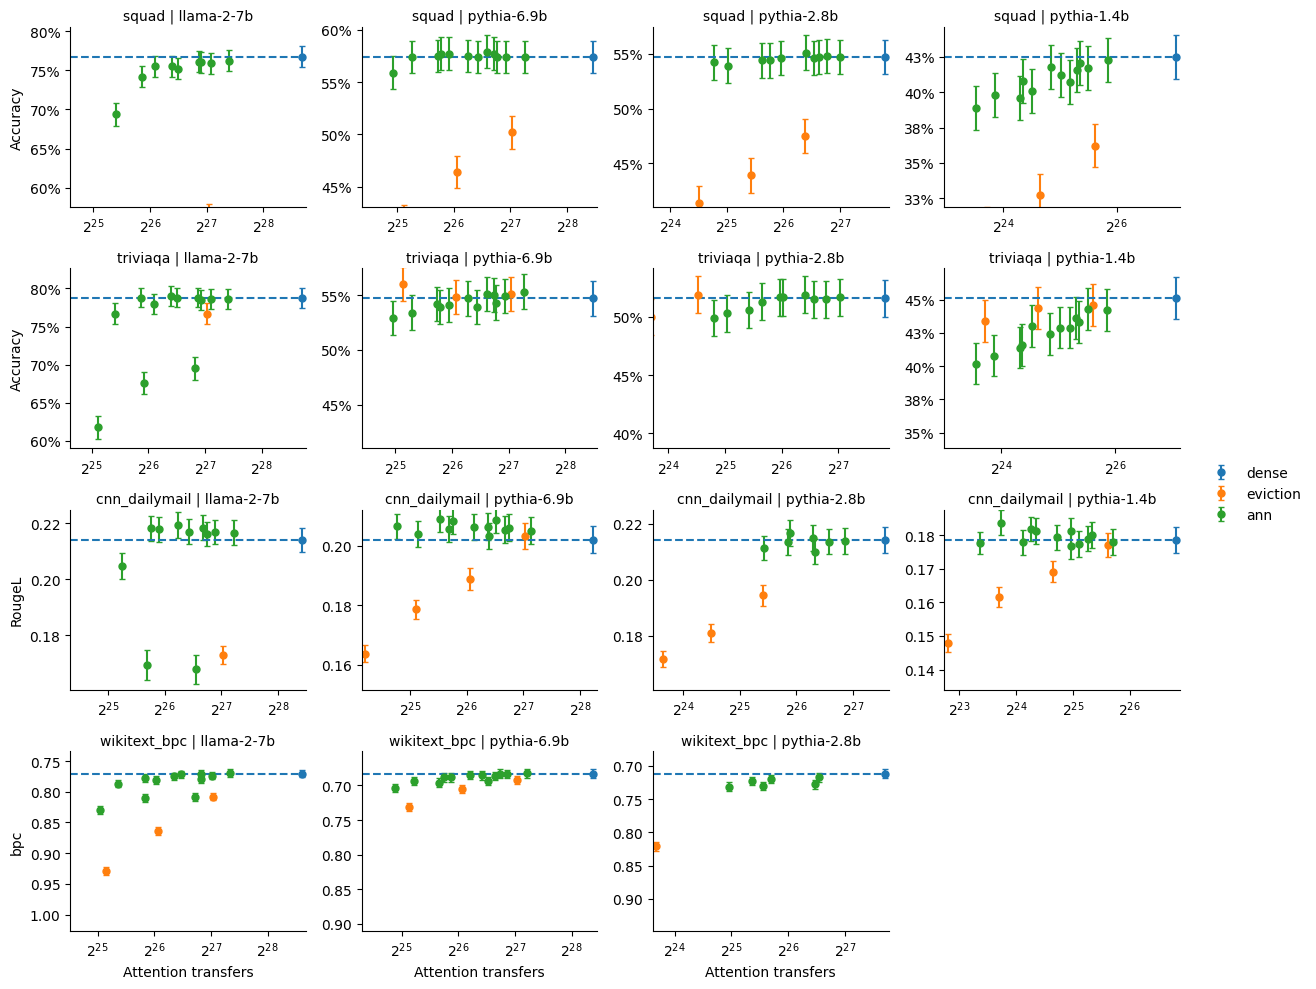

In [7]:
tasks = ["squad", "triviaqa", "cnn_dailymail", "wikitext_bpc"]
models = ["llama-2-7b", "pythia-6.9b", "pythia-2.8b", "pythia-1.4b"]

fig, axs = plt.subplots(len(tasks), len(models), figsize=(3*len(models), 2.5*len(tasks)))

for task, axr in zip(tasks, axs):
    for model, ax in zip(models, axr):
        sns.despine(ax=ax)
        ax.set_title(f"{task} | {model}", fontsize=10, pad=5)
        if model == models[0]:
            ax.set_ylabel(dict(squad="Accuracy", triviaqa="Accuracy", cnn_dailymail="RougeL", wikitext_bpc="bpc")[task])
        if task in ["squad", "triviaqa"]:
            ax.yaxis.set_major_formatter("{x:.0%}")

        d = df[(df.task==task) & (df.model==model)]
        if len(d):
            for name in ["dense", "eviction", "ann"]:
                g = d[d.name==name]
                ax.errorbar(x=g.transfers, y=g.score, yerr=g.score_stderr, fmt="o", ms=5, capsize=2, label=name)
            g = d[d.name=="dense"]
            transfers = g.transfers.item()
            score = g.score.item()
            ax.hlines(score, transfers/17, transfers*1.05, linestyles="--")
            ax.set_xscale("log", base=2)
            ax.set_xlim((transfers/17, transfers*1.05))
            ax.set_ylim((score/.75, score/1.05) if task == "wikitext_bpc" else (score*.75, score*1.05))
        else:
            ax.remove()

for ax in axs[-1, :]:
    ax.set_xlabel("Attention transfers")
fig.legend(*axs[0, 0].get_legend_handles_labels(), loc="center left", bbox_to_anchor=(1.0, 0.5), frameon=False)
plt.tight_layout()

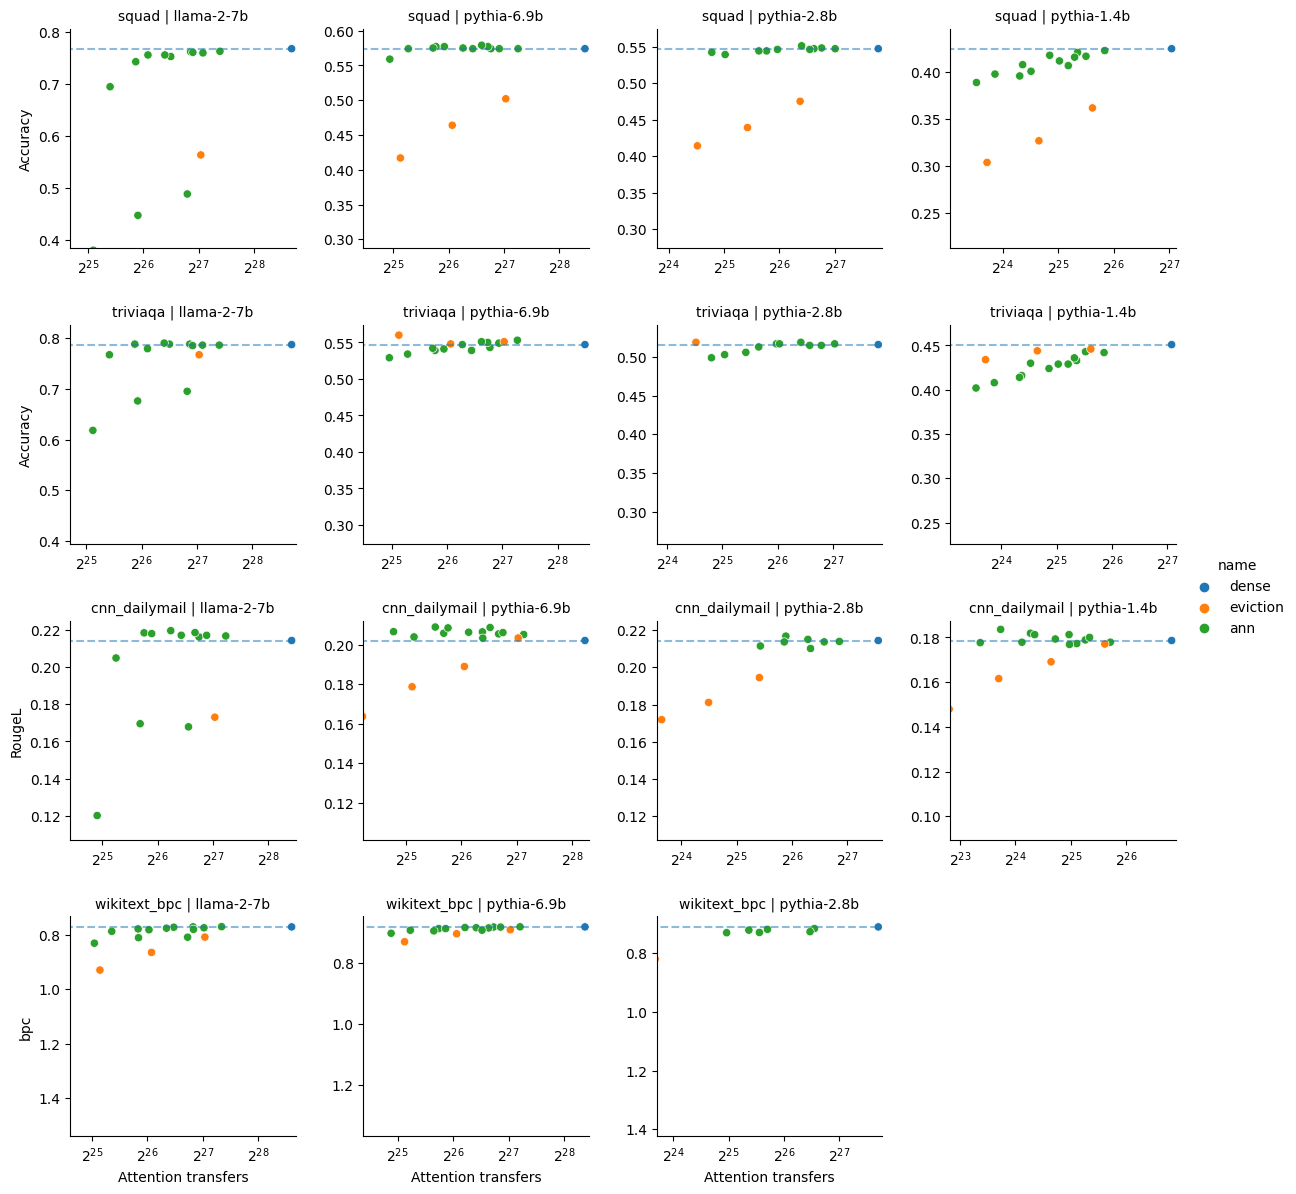

In [6]:
g = sns.relplot(data=df, y="score", x="transfers",
                hue="name", hue_order=["dense", "eviction", "ann"],
                row="task", row_order=["squad", "triviaqa", "cnn_dailymail", "wikitext_bpc"],
                col="model", col_order=["llama-2-7b", "pythia-6.9b", "pythia-2.8b", "pythia-1.4b"],
                facet_kws=dict(sharex=False, sharey=False), height=3, aspect=1)

for (task, model), ax in g.axes_dict.items():
    d = df[(df.task==task)&(df.model==model)&(df.name=="dense")]
    if len(d):
        baseline = d.score.item()
        ax.hlines([baseline], *ax.get_xlim(), sns.color_palette()[0], linestyles="--", alpha=.5)
        ax.set_ylim((baseline*2, baseline*.95) if task == "wikitext_bpc" else (baseline*.5, baseline*1.05))
        baseline_transfers = d.transfers.item()
        ax.set_xlim((baseline_transfers/16, baseline_transfers*1.05))
        ax.set_title(f"{task} | {model}", fontsize=10)
        ax.set_xscale("log", base=2)
        if task == "wikitext_bpc":
            ax.set_xlabel("Attention transfers")
        if model == "llama-2-7b":
            ax.set_ylabel(dict(squad="Accuracy", triviaqa="Accuracy", cnn_dailymail="RougeL", wikitext_bpc="bpc")[task])
    else:
        ax.remove()

# What is the recipe between rank & k

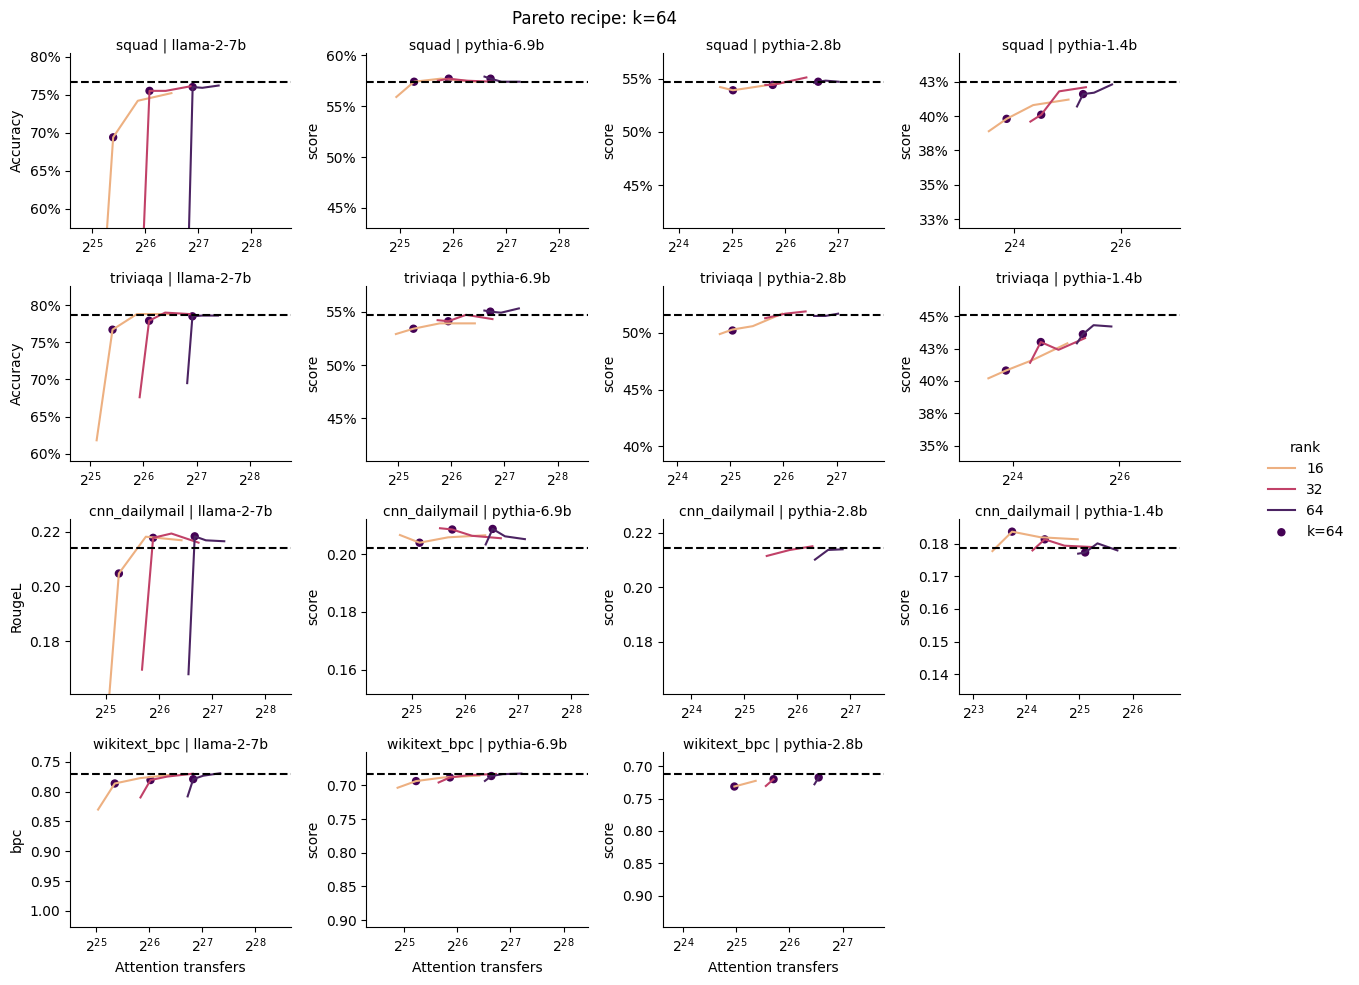

In [9]:
k_opt = 64
tasks = ["squad", "triviaqa", "cnn_dailymail", "wikitext_bpc"]
models = ["llama-2-7b", "pythia-6.9b", "pythia-2.8b", "pythia-1.4b"]

fig, axs = plt.subplots(len(tasks), len(models), figsize=(3*len(models), 2.5*len(tasks)), squeeze=False)

for task, axr in zip(tasks, axs):
    for model, ax in zip(models, axr):
        sns.despine(ax=ax)
        ax.set_title(f"{task} | {model}", fontsize=10, pad=0)
        if model == models[0]:
            ax.set_ylabel(dict(squad="Accuracy", triviaqa="Accuracy", cnn_dailymail="RougeL", wikitext_bpc="bpc")[task])
        if task in ["squad", "triviaqa"]:
            ax.yaxis.set_major_formatter("{x:.0%}")

        d = df[(df.task==task) & (df.model==model)]
        if len(d):
            sns.lineplot(data=d[d.name=="ann"].pipe(lambda d: d.assign(rank=d["rank"].astype("long"))), y="score", x="transfers", hue="rank", ax=ax,
                         hue_norm=matplotlib.colors.LogNorm(), palette="flare")
            ax.scatter(data=d[(d.name=="ann")&(d.k==k_opt)], y="score", x="transfers", c='k', label=f"k={k_opt}", s=25)

            g = d[d.name=="dense"]
            transfers = g.transfers.item()
            score = g.score.item()
            ax.hlines(score, transfers/17, transfers*1.05, linestyles="--", colors="k")
            ax.set_xscale("log", base=2)
            ax.set_xlim((transfers/17, transfers*1.05))
            ax.set_ylim((score/.75, score/1.05) if task == "wikitext_bpc" else (score*.75, score*1.05))
            ax.legend_.remove()
            ax.set_xlabel("")
        else:
            ax.remove()

for ax in axs[-1, :]:
    ax.set_xlabel("Attention transfers")
fig.legend(*axs[0, 0].get_legend_handles_labels(), title="rank", loc="center left", bbox_to_anchor=(1.05, 0.5), frameon=False)
plt.suptitle(f"Pareto recipe: k={k_opt}")
plt.tight_layout()